# Classification with Claude: Insurance Support Ticket Classifier

In this guide, you'll build a high-accuracy classification system that categorizes insurance support tickets into 10 categories. You'll learn how to progressively improve classification accuracy from 70% to 95%+ by combining prompt engineering, retrieval-augmented generation (RAG), and chain-of-thought reasoning.

By the end of this guide, you'll understand how to design classification systems that handle complex business rules, work with limited training data, and provide explainable results.

## Prerequisites
- Python 3.11+ with basic familiarity
- Anthropic API key ([get one here](https://console.anthropic.com))
- VoyageAI API key (optional - embeddings are pre-computed)
- Understanding of classification problems

## Setup

First, we will install the required packages

- anthropic 
- voyageai
- pandas
- matplotlib
- sklearn
- numpy

We will also load the API keys from the environment and set our model name.

In [1]:
%%capture
!pip install -U anthropic voyageai pandas numpy matplotlib scikit-learn

In [ ]:
# Setup our environment
import anthropic
import os

MODEL = "claude-haiku-4-5"
client = anthropic.Anthropic(
    # This is the default and can be omitted
    api_key=os.getenv("ANTHROPIC_API_KEY"),
)

## Classification with Claude

Large Language Models (LLMs) have revolutionized the field of classification, particularly in areas where traditional machine learning systems have faced challenges. LLMs have demonstrated remarkable success in handling classification problems characterized by complex business rules and scenarios with low-quality or limited training data. Additionally, LLMs have the capability of providing natural language explanations and justifications for their actions, enhancing the interpretability and transparency of the classification process. By leveraging the power of LLMs, we can build classification systems that go beyond the capabilities of traditional machine learning approaches and excel in scenarios where data is scarce or business requirements are intricate.

In this guide, we will explore how LLMs can be leveraged to tackle advanced classification tasks. We will cover the following key components and steps:

1. **Data Preparation**: We will begin by preparing our training and test data. The training data will be used to build the classification model, while the test data will be utilized to assess its performance. Proper data preparation is crucial to ensure the effectiveness of our classification system.

2. **Prompt Engineering**: Prompt engineering plays a vital role in harnessing the power of LLMs for classification. We will design a prompt template that defines the structure and format of the prompts used for classification. The prompt template will incorporate the user query, class definitions, and relevant examples from the vector database. By carefully crafting the prompts, we can guide the LLM to generate accurate and contextually relevant classifications.

3. **Implementing Retrieval-Augmented Generation (RAG)**: To enhance the classification process, we will employ a vector database to store and efficiently retrieve embeddings of our training data. The vector database enables similarity searches, allowing us to find the most relevant examples for a given query. By augmenting the LLM with retrieved examples, we can provide additional context and improve the accuracy of the generated classifications.

4. **Testing and Evaluation**: Once our classification system is built, we will rigorously test its performance using the transformed test data. We will iterate over the test queries, classify each query using the classification function, and compare the predicted categories with the expected categories. By analyzing the classification results, we can evaluate the effectiveness of our system and identify areas for improvement.

## Problem Definition: Insurance Support Ticket Classifier

*Note: The problem definition, data, and labels used in this example were synthetically generated by Claude 3 Opus*

In the insurance industry, customer support plays a crucial role in ensuring client satisfaction and retention. Insurance companies receive a high volume of support tickets daily, covering a wide range of topics such as billing, policy administration, claims assistance, and more. Manually categorizing these tickets can be time-consuming and inefficient, leading to longer response times and potentially impacting customer experience.

#### Category Definitions

1. Billing Inquiries
- Questions about invoices, charges, fees, and premiums
- Requests for clarification on billing statements
- Inquiries about payment methods and due dates

2. Policy Administration
- Requests for policy changes, updates, or cancellations
- Questions about policy renewals and reinstatements
- Inquiries about adding or removing coverage options

3. Claims Assistance
- Questions about the claims process and filing procedures
- Requests for help with submitting claim documentation
- Inquiries about claim status and payout timelines

4. Coverage Explanations
- Questions about what is covered under specific policy types
- Requests for clarification on coverage limits and exclusions
- Inquiries about deductibles and out-of-pocket expenses


5. Quotes and Proposals
- Requests for new policy quotes and price comparisons
- Questions about available discounts and bundling options
- Inquiries about switching from another insurer


6. Account Management
- Requests for login credentials or password resets
- Questions about online account features and functionality
- Inquiries about updating contact or personal information


7. Billing Disputes
- Complaints about unexpected or incorrect charges
- Requests for refunds or premium adjustments
- Inquiries about late fees or collection notices


8. Claims Disputes
- Complaints about denied or underpaid claims
- Requests for reconsideration of claim decisions
- Inquiries about appealing a claim outcome


9. Policy Comparisons
- Questions about the differences between policy options
- Requests for help deciding between coverage levels
- Inquiries about how policies compare to competitors' offerings


10. General Inquiries
- Questions about company contact information or hours of operation
- Requests for general information about products or services
- Inquiries that don't fit neatly into other categories




## Loading and Preparing the Data

Now that we've defined our problem and categories, let's load the labeled training and test data. We'll read the TSV files, convert them into a structured format, and prepare our test set for evaluation.

The training data contains 68 labeled examples that we'll use for retrieval-augmented generation (RAG) later. The test set also contains 68 examples that we'll use to evaluate our classification approaches.

We will use the following datasets:
- `./data/test.tsv`
- `./data/train.tsv`

In [3]:
import pandas as pd

data = {
    "train": [],
    "test": [],
}


# Helper function to convert a DataFrame to a list of dictionaries
def dataframe_to_dict_list(df):
    return df.apply(lambda x: {"text": x["text"], "label": x["label"]}, axis=1).tolist()


# Read the TSV file into a DataFrame
test_df = pd.read_csv("./data/test.tsv", sep="\t")
data["test"] = dataframe_to_dict_list(test_df)

train_df = pd.read_csv("./data/train.tsv", sep="\t")
data["train"] = dataframe_to_dict_list(train_df)


# Understand the labels in the dataset
labels = list(set(train_df["label"].unique()))

# Print the first training example and the number of training examples
print(data["train"][0], len(data["train"]))

# Create the test set
X_test = [example["text"] for example in data["test"]]
y_test = [example["label"] for example in data["test"]]

# Print the length of the test set
print(len(X_test), len(y_test))

{'text': 'I just got my auto policy renewal bill and the cost seems to be more than what I usually pay. Could you explain the reason for the increase?', 'label': 'Billing Inquiries'} 68
68 68


## Evaluation Framework

Before we build our classifiers, let's set up an evaluation framework to measure their performance. We'll create two key functions:

1. **`evaluate(X, y, classifier, batch_size)`**: Runs your classifier on all test examples using concurrent execution for speed, then calculates accuracy metrics and generates a confusion matrix. The `batch_size` parameter controls how many concurrent API requests to make.

2. **`plot_confusion_matrix(cm, labels)`**: Visualizes the confusion matrix to show which categories are being confused with each other, helping identify where the classifier struggles.

This framework allows us to empirically compare different classification approaches and understand not just overall accuracy, but which specific categories are challenging.

**Rate Limits**: The `MAXIMUM_CONCURRENT_REQUESTS` is set to 1 by default. If you have a higher rate limit tier, you can increase this value to speed up evaluation. See [rate limits documentation](https://docs.claude.com/en/api/rate-limits) for your tier's limits.

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import concurrent.futures
import numpy as np

MAXIMUM_CONCURRENT_REQUESTS = 5


def plot_confusion_matrix(cm, labels):
    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap="Blues")

    # Add colorbar
    ax.figure.colorbar(im, ax=ax)

    # Set tick labels and positions
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    # Add labels to each cell
    thresh = cm.max() / 2.0
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(
                j,
                i,
                cm[i, j],
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    # Set labels and title
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


def evaluate(X, y, classifier, batch_size=MAXIMUM_CONCURRENT_REQUESTS):
    # Initialize lists to store the predicted and true labels
    y_true = []
    y_pred = []

    # Store results with their original index to maintain order
    results = [None] * len(X)

    # Create a ThreadPoolExecutor with limited workers
    with concurrent.futures.ThreadPoolExecutor(max_workers=batch_size) as executor:
        # Submit tasks one at a time, but executor will only run batch_size concurrently
        future_to_index = {executor.submit(classifier, x): i for i, x in enumerate(X)}

        # Process results as they complete
        for future in concurrent.futures.as_completed(future_to_index):
            index = future_to_index[future]
            predicted_label = future.result()
            results[index] = predicted_label

    # Extract predictions and true labels in order
    y_pred = results
    y_true = y

    # Normalize y_true and y_pred
    y_true = [label.strip() for label in y_true]
    y_pred = [label.strip() for label in y_pred]

    # Calculate the classification metrics
    report = classification_report(y_true, y_pred, labels=labels, zero_division=1)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(report)
    plot_confusion_matrix(cm, labels)

## Baseline: Random Classifier

To establish a performance baseline and verify our evaluation framework works correctly, let's start with a random classifier that picks a category at random for each ticket.

This gives us a lower bound on performance: any real classification approach should significantly outperform random guessing (which should achieve roughly 10% accuracy with 10 categories). This baseline helps us quantify how much value our context engineering actually adds.

In [5]:
import random


def random_classifier(text):
    return random.choice(labels)

Evaluating the random classification method on the test set...
                       precision    recall  f1-score   support

    Claims Assistance       0.14      0.17      0.15         6
 Quotes and Proposals       0.40      0.40      0.40         5
      Claims Disputes       0.38      0.33      0.35         9
Coverage Explanations       0.29      0.22      0.25         9
     Billing Disputes       0.20      0.11      0.14         9
Policy Administration       0.25      0.33      0.29         6
    Billing Inquiries       0.00      0.00      0.00         6
    General Inquiries       0.00      0.00      0.00         7
   Policy Comparisons       0.00      0.00      0.00         5
   Account Management       0.00      0.00      0.00         6

             accuracy                           0.16        68
            macro avg       0.17      0.16      0.16        68
         weighted avg       0.18      0.16      0.17        68



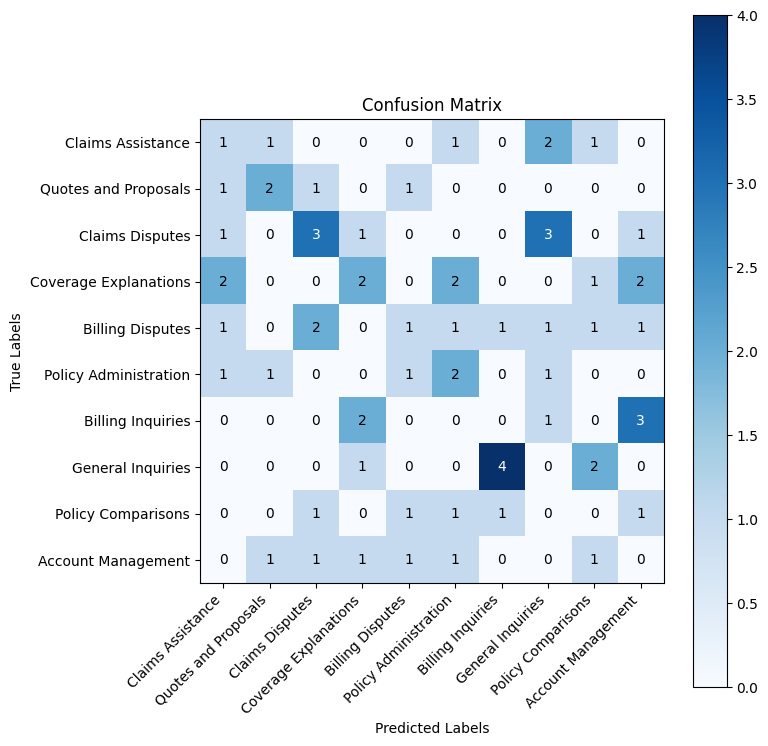

In [6]:
print("Evaluating the random classification method on the test set...")
evaluate(X_test, y_test, random_classifier)

As expected from random guessing, the confusion matrix shows predictions scattered across all categories with no meaningful pattern. The diagonal (correct predictions) shows only 1-4 correct classifications per category, while errors are distributed randomly. 

This confirms our baseline of approximately 10% accuracy—purely chance performance with 10 categories. Any structured classification approach should show a much stronger diagonal pattern, indicating the model is actually learning the category distinctions rather than guessing.


### Simple Classification Test

Now lets construct a simple classifier using Claude.

First we will encode the categories in XML format. This will make it easier for Claude to interpret the information. Encoding information in XML is a general prompting strategy, for more information [see here](https://docs.claude.com/en/docs/build-with-claude/prompt-engineering/use-xml-tags)

In [7]:
import textwrap

categories = textwrap.dedent("""<category> 
    <label>Billing Inquiries</label>
    <content> Questions about invoices, charges, fees, and premiums Requests for clarification on billing statements Inquiries about payment methods and due dates 
    </content> 
</category> 
<category> 
    <label>Policy Administration</label>
    <content> Requests for policy changes, updates, or cancellations Questions about policy renewals and reinstatements Inquiries about adding or removing coverage options 
    </content> 
</category> 
<category> 
    <label>Claims Assistance</label> 
    <content> Questions about the claims process and filing procedures Requests for help with submitting claim documentation Inquiries about claim status and payout timelines 
    </content> 
</category> 
<category> 
    <label>Coverage Explanations</label> 
    <content> Questions about what is covered under specific policy types Requests for clarification on coverage limits and exclusions Inquiries about deductibles and out-of-pocket expenses 
    </content> 
</category> 
<category> 
    <label>Quotes and Proposals</label> 
    <content> Requests for new policy quotes and price comparisons Questions about available discounts and bundling options Inquiries about switching from another insurer 
    </content> 
</category> 
<category> 
    <label>Account Management</label> 
    <content> Requests for login credentials or password resets Questions about online account features and functionality Inquiries about updating contact or personal information 
    </content> 
</category> 
<category> 
    <label>Billing Disputes</label> 
    <content> Complaints about unexpected or incorrect charges Requests for refunds or premium adjustments Inquiries about late fees or collection notices 
    </content> 
</category> 
<category> 
    <label>Claims Disputes</label> 
    <content> Complaints about denied or underpaid claims Requests for reconsideration of claim decisions Inquiries about appealing a claim outcome 
    </content> 
</category> 
<category> 
    <label>Policy Comparisons</label> 
    <content> Questions about the differences between policy options Requests for help deciding between coverage levels Inquiries about how policies compare to competitors' offerings 
    </content> 
</category> 
<category> 
    <label>General Inquiries</label> 
    <content> Questions about company contact information or hours of operation Requests for general information about products or services Inquiries that don't fit neatly into other categories 
    </content> 
</category>""")

## Building the Simple Classifier

Now let's build our first real classifier using Claude. The `simple_classify` function demonstrates three key prompt engineering techniques:

1. **Structured prompt template**: We provide the category definitions and the support ticket in a clear XML format, making it easy for Claude to parse the information.

2. **Controlled output with prefilling**: By starting the assistant's response with `<category>` and setting `stop_sequences=["</category>"]`, we force Claude to output just the category label—no explanation or extra text. This makes response parsing reliable and deterministic.

3. **Deterministic classification**: Setting `temperature=0.0` ensures consistent predictions for the same input, which is critical for classification tasks.


In [ ]:
def simple_classify(X):
    prompt = (
        textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Respond with just the label of the category between category tags.
    """)
        .replace("{{categories}}", categories)
        .replace("{{ticket}}", X)
    )
    response = client.messages.create(
        messages=[
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": "<category>"},
        ],
        stop_sequences=["</category>"],
        max_tokens=4096,
        temperature=0.0,
        model=MODEL,
    )

    # Extract the result from the response
    result = response.content[0].text  # pyright: ignore[reportAttributeAccessIssue]
    return result.strip()

Evaluating the simple classification method on the test set...
                       precision    recall  f1-score   support

    Claims Assistance       1.00      0.67      0.80         6
 Quotes and Proposals       1.00      0.60      0.75         5
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       0.53      1.00      0.69         9
     Billing Disputes       0.67      0.67      0.67         9
Policy Administration       0.71      0.83      0.77         6
    Billing Inquiries       0.50      0.50      0.50         6
    General Inquiries       1.00      0.00      0.00         7
   Policy Comparisons       0.71      1.00      0.83         5
   Account Management       1.00      1.00      1.00         6

             accuracy                           0.74        68
            macro avg       0.81      0.73      0.70        68
         weighted avg       0.80      0.74      0.70        68



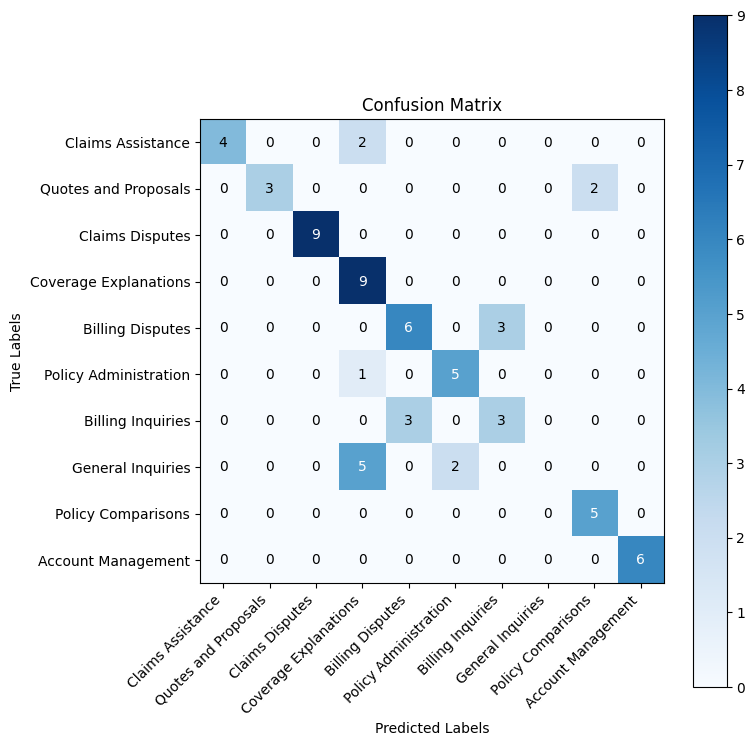

In [9]:
print("Evaluating the simple classification method on the test set...")
evaluate(X_test, y_test, simple_classify)

Much better! The confusion matrix shows a strong diagonal pattern with most categories achieving high accuracy. 

This ~70% overall accuracy significantly outperforms random guessing, but the confusion between similar categories suggests Claude needs more context to make finer distinctions.

To address these confusion patterns, we'll add **retrieval-augmented generation (RAG)** by providing Claude with relevant examples from our training data. Here's how it works:

1. **Embed training examples**: Convert all 68 training tickets into vector embeddings using VoyageAI's embedding model
2. **Semantic search**: For each new ticket, find the 5 most similar training examples based on cosine similarity
3. **Augment the prompt**: Include these similar examples in the classification prompt to guide Claude

This approach is particularly effective for classification because:
- Similar past examples help Claude distinguish between semantically close categories
- Few-shot learning improves accuracy without fine-tuning
- The retrieval is dynamic—each query gets the most relevant examples

We'll build a simple `VectorDB` class to handle embedding storage and similarity search using [VoyageAI's embedding models](https://docs.claude.com/en/docs/embeddings).

In [14]:
import os
import numpy as np
import voyageai
import pickle
import json


class VectorDB:
    def __init__(self, api_key=None):
        if api_key is None:
            api_key = os.getenv("VOYAGE_API_KEY")
        self.client = voyageai.Client(api_key=api_key)
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = "./data/vector_db.pkl"

    def load_data(self, data):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        texts = [item["text"] for item in data]

        # Embed more than 128 documents with a for loop
        batch_size = 128
        result = [
            self.client.embed(texts[i : i + batch_size], model="voyage-2").embeddings
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = [item for item in data]
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=5, similarity_threshold=0.75):
        query_embedding = None
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self.client.embed([query], model="voyage-2").embeddings[0]
            self.query_cache[query] = query_embedding

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []

        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)

                if len(top_examples) >= k:
                    break
        self.save_db()
        return top_examples

    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError(
                "Vector database file not found. Use load_data to create a new database."
            )

        with open(self.db_path, "rb") as file:
            data = pickle.load(file)

        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

We can define the vector db and load our training data.

VoyageAI has a rate limit of 3RPM for accounts without an associated credit card. For ease of demonstration we will leverage a cache.

In [15]:
vectordb = VectorDB()
vectordb.load_data(data["train"])

Loading vector database from disk.


## RAG-Enhanced Classifier

Now let's rebuild our classifier with retrieval-augmented generation. The `rag_classify` function enhances the simple classifier by:

1. **Retrieving similar examples**: For each ticket, we search the vector database for the 5 most semantically similar training examples
2. **Formatting as few-shot examples**: We structure these examples in XML format with `<query>` and `<label>` tags, showing Claude how similar tickets were classified
3. **Augmenting the prompt**: We inject these examples into the prompt before asking Claude to classify the new ticket

This few-shot learning approach helps Claude make better distinctions between similar categories by showing concrete examples of how tickets with similar language should be categorized. For instance, if the test ticket mentions "unexpected charges," retrieving examples of past "Billing Disputes" vs "Billing Inquiries" helps Claude understand the subtle difference.

Let's see how much this improves our accuracy on the confused categories from the previous run.

In [17]:
def rag_classify(X):
    rag = vectordb.search(X, 5)
    rag_string = ""
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    prompt = (
        textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    Respond with just the label of the category between category tags.
    """)
        .replace("{{categories}}", categories)
        .replace("{{ticket}}", X)
        .replace("{{examples}}", rag_string)
    )
    response = client.messages.create(
        messages=[
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": "<category>"},
        ],
        stop_sequences=["</category>"],
        max_tokens=4096,
        temperature=0.0,
        model="claude-haiku-4-5",
    )

    # Extract the result from the response
    result = response.content[0].text.strip()
    return result

Evaluating the RAG method on the test set...
                       precision    recall  f1-score   support

    Claims Assistance       1.00      1.00      1.00         6
 Quotes and Proposals       1.00      1.00      1.00         5
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       0.82      1.00      0.90         9
     Billing Disputes       0.82      1.00      0.90         9
Policy Administration       1.00      1.00      1.00         6
    Billing Inquiries       1.00      0.67      0.80         6
    General Inquiries       1.00      0.71      0.83         7
   Policy Comparisons       1.00      1.00      1.00         5
   Account Management       1.00      1.00      1.00         6

             accuracy                           0.94        68
            macro avg       0.96      0.94      0.94        68
         weighted avg       0.95      0.94      0.94        68



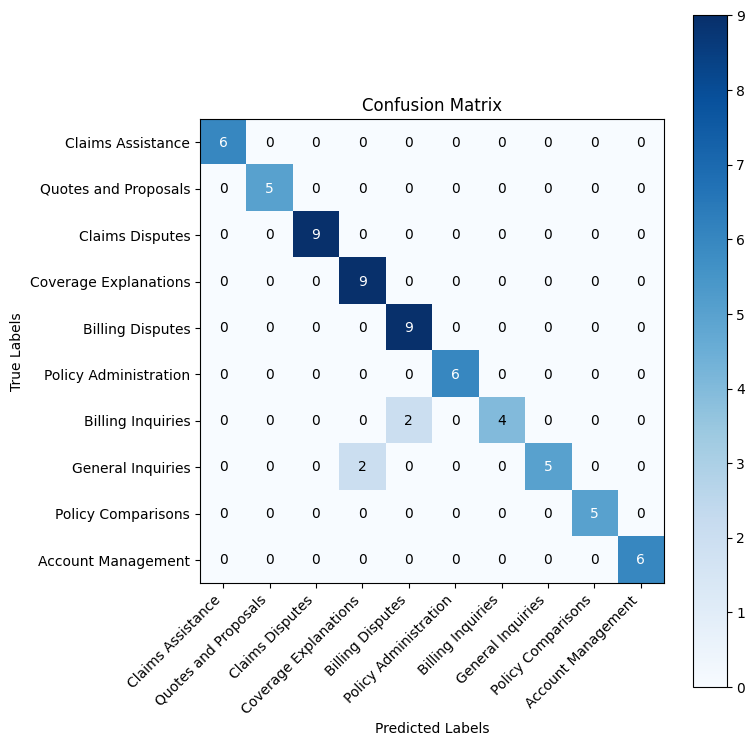

In [18]:
print("Evaluating the RAG method on the test set...")
evaluate(X_test, y_test, rag_classify)

## RAG Results Analysis

RAG boosted our accuracy from ~70% to **94%**. The confusion matrix shows a much stronger diagonal, with most categories now achieving perfect or near-perfect accuracy.

The few remaining errors suggest that even with relevant examples, some edge cases remain ambiguous. This is where chain-of-thought reasoning can help Claude think through the subtle distinctions more carefully.

## RAG with Chain-of-Thought Reasoning

Chain-of-thought (CoT) prompting asks Claude to "think out loud" before making a classification decision. 

This explicit reasoning process helps Claude catch subtle distinctions that might be missed with direct classification. For example, distinguishing "I have a question about my bill" (Billing Inquiry) from "This charge seems wrong" (Billing Dispute) requires understanding intent and tone—something that benefits from step-by-step analysis.

The `rag_chain_of_thought_classify` function adds a `<scratchpad>` section where Claude works through this reasoning before outputting the final `<category>`.

In [ ]:
def rag_chain_of_thought_classify(X):
    rag = vectordb.search(X, 5)
    rag_string = ""
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    prompt = (
        textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    First you will think step-by-step about the problem in scratchpad tags.
    You should consider all the information provided and create a concrete argument for your classification.
    
    Respond using this format:
    <response>
        <scratchpad>Your thoughts and analysis go here</scratchpad>
        <category>The category label you chose goes here</category>
    </response>
    """)
        .replace("{{categories}}", categories)
        .replace("{{ticket}}", X)
        .replace("{{examples}}", rag_string)
    )
    response = client.messages.create(
        messages=[
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": "<response><scratchpad>"},
        ],
        stop_sequences=["</category>"],
        max_tokens=4096,
        temperature=0.0,
        model=MODEL,
    )

    # Extract the result from the response
    result = response.content[0].text.split("<category>")[1].strip()
    return result

Evaluating the RAG method with Chain of Thought on the test set...
                       precision    recall  f1-score   support

    Claims Assistance       1.00      1.00      1.00         6
 Quotes and Proposals       1.00      1.00      1.00         5
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       1.00      1.00      1.00         9
     Billing Disputes       0.82      1.00      0.90         9
Policy Administration       1.00      1.00      1.00         6
    Billing Inquiries       1.00      0.67      0.80         6
    General Inquiries       1.00      1.00      1.00         7
   Policy Comparisons       1.00      1.00      1.00         5
   Account Management       1.00      1.00      1.00         6

             accuracy                           0.97        68
            macro avg       0.98      0.97      0.97        68
         weighted avg       0.98      0.97      0.97        68



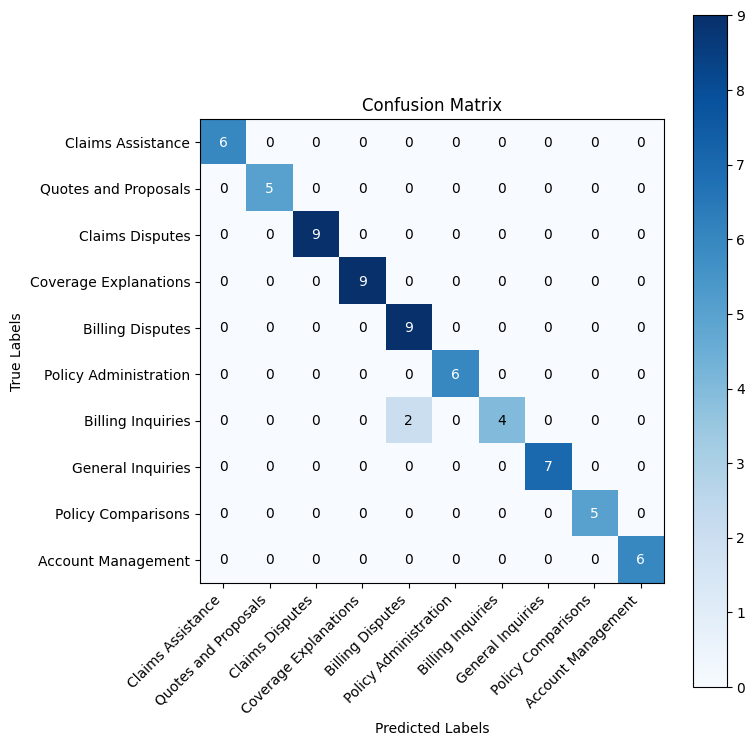

In [20]:
print("Evaluating the RAG method with Chain of Thought on the test set...")
evaluate(X_test, y_test, rag_chain_of_thought_classify)

## Chain-of-Thought Results Analysis

Chain-of-thought reasoning pushed our accuracy to **97%**, resolving most of the edge cases that challenged the previous approaches.

**Progressive improvement summary:**
- Random baseline: ~10% accuracy
- Simple classifier: ~70% accuracy
- RAG classifier: 94% accuracy  
- **RAG + Chain-of-Thought: 97% accuracy**

By explicitly reasoning through each classification decision, Claude better distinguishes between ambiguous cases. 

# Scaling Evaluation with Promptfoo

Throughout this guide, we've demonstrated the importance of **empirical evaluation** when engineering prompts. Rather than relying on intuition, we measured performance at each step:

- Random baseline: ~10% → Simple: ~70% → RAG: 94% → RAG + CoT: 97%

This data-driven approach revealed exactly which techniques (RAG, chain-of-thought) added value and by how much. For more on this methodology, see our [prompt engineering guide](https://docs.claude.com/en/docs/prompt-engineering).

## Moving Beyond Notebooks

While Jupyter notebooks are excellent for rapid iteration and exploration, production classification systems require more robust evaluation infrastructure:

- **Larger test sets**: You'll want to evaluate on hundreds or thousands of examples, not just 68
- **Multiple prompt variants**: A/B testing different phrasings, structures, and approaches
- **Model comparisons**: Testing across different Claude models (Haiku vs Sonnet) or temperature settings
- **Regression detection**: Ensuring prompt changes don't accidentally hurt accuracy
- **Version control**: Tracking prompt performance over time as your system evolves

This is where dedicated evaluation tools like [Promptfoo](https://www.promptfoo.dev/) become essential.

## Running Promptfoo Evaluation

Promptfoo is an open-source LLM evaluation toolkit that automates prompt testing across multiple configurations. For this guide, we've set up a Promptfoo evaluation that tests all three approaches (Simple, RAG, RAG w/ CoT) across different temperature settings.

**To run the evaluation:**

1. Navigate to the evaluation directory: `cd ./evaluation`
2. Follow the setup instructions in `./evaluation/README.md`
3. Run the evaluation and return here to analyze the results below

The results will show how each prompt variant performs across the full test set, revealing patterns that might not be obvious from notebook testing alone.

In [21]:
import json
import pandas as pd

promptfoo_results = pd.read_csv("./data/results.csv")
examples_columns = promptfoo_results.columns[2:]

number_of_providers = 5
number_of_prompts = 3

prompts = ["Simple", "RAG", "RAG w/ CoT"]

columns = ["label", "text"] + [
    json.loads(examples_columns[prompt * number_of_providers + provider])["provider"]
    + " Prompt: "
    + str(prompts[prompt])
    for prompt in range(number_of_prompts)
    for provider in range(number_of_providers)
]

promptfoo_results.columns = columns

result = (
    promptfoo_results.iloc[:, 2:].astype(str).apply(lambda x: x.str.count("PASS")).sum()
    / len(promptfoo_results)
    * 100
).sort_values(ascending=False)

print(result)

Haiku: T-0.0 Prompt: RAG w/ CoT    95.588235
Haiku: T-0.2 Prompt: RAG w/ CoT    95.588235
Haiku: T-0.8 Prompt: RAG w/ CoT    95.588235
Haiku: T-0.0 Prompt: RAG           94.117647
Haiku: T-0.4 Prompt: RAG           94.117647
Haiku: T-0.6 Prompt: RAG           94.117647
Haiku: T-0.4 Prompt: RAG w/ CoT    94.117647
Haiku: T-0.6 Prompt: RAG w/ CoT    94.117647
Haiku: T-0.2 Prompt: RAG           92.647059
Haiku: T-0.8 Prompt: RAG           89.705882
Haiku: T-0.6 Prompt: Simple        72.058824
Haiku: T-0.0 Prompt: Simple        70.588235
Haiku: T-0.2 Prompt: Simple        70.588235
Haiku: T-0.8 Prompt: Simple        70.588235
Haiku: T-0.4 Prompt: Simple        69.117647
dtype: float64


## Systematic Evaluation with Promptfoo

The results above demonstrate the power of systematic prompt evaluation at scale. While our notebook provided quick iteration during development, [Promptfoo](https://www.promptfoo.dev/) enabled us to rigorously test our prompts across multiple dimensions:

### What We Tested

Using Promptfoo, we evaluated all three prompt approaches (Simple, RAG, RAG w/ CoT) across:
- **Multiple temperature settings** (0.0, 0.2, 0.4, 0.6, 0.8): Testing whether deterministic classification (T=0.0) outperforms slightly randomized outputs
- **The same test set** (68 examples): Ensuring fair comparison across all configurations
- **Automated pass/fail checking**: Each prediction is automatically compared against ground truth labels

### Key Findings

The Promptfoo results confirm our notebook findings while revealing additional insights:

1. **Temperature has minimal impact on CoT**: RAG w/ CoT achieves 95.59% accuracy consistently across T=0.0, 0.2, and 0.8, suggesting the chain-of-thought reasoning stabilizes outputs regardless of sampling randomness

2. **RAG is robust to temperature variation**: RAG performance stays strong (89-94%) across most temperature settings, though T=0.0 performs best (94.12%)

3. **Simple prompts are temperature-agnostic**: The simple classifier hovers around 70% accuracy regardless of temperature, confirming that without RAG or CoT, the model relies primarily on category definitions

4. **Production recommendation**: Use `temperature=0.0` with RAG w/ CoT for maximum consistency and accuracy (95.59%)

To run these evaluations yourself, see `./evaluation/README.md` for setup instructions.